In [24]:
import os
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [17]:
#get file paths
cwd = os.getcwd()
data_dir = os.path.join(cwd, "..","..","..","Final Data")

train_path = os.path.join(data_dir,"train.csv")
val_path = os.path.join(data_dir,"val.csv")
test_path = os.path.join(data_dir,"test.csv")


#read files
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
val_df = pd.read_csv(val_path)

#assign labels to columns
X_train, y_train = train_df["text"].astype(str), train_df["fake"].astype(int)
X_test, y_test = test_df["text"].astype(str), test_df["fake"].astype(int)
X_val, y_val = val_df["text"].astype(str), val_df["fake"].astype(int)

#import cnn prediction report for comparision
cnn_dir = os.path.join(cwd, "..","..","CNN","preds","cnn")
cnn_path = os.path.join(cnn_dir,"test_preds.csv")
cnnTest_df = pd.read_csv(cnn_path)
cnnTest, cnnTestPred = cnnTest_df["y_true"].astype(int), cnnTest_df["y_pred"].astype(int)



In [13]:
#validate

#hyper params
ngram_range = [(1,1),(1,2),(1,3),(1,4)] #group word classes
max_features = [3000, 5000, 7000, 9000] #maximum amount of unique features (words) used
alphas = [0.1, 0.5, 1.0, 1.5] 

Highest_Accuracy = 0
Best_Params = None


for alpha in alphas:
    for ngram in ngram_range:
        for max_feature in max_features:

            #tokenise
            vectorizer = TfidfVectorizer(
                max_features = max_feature,
                ngram_range = ngram,
                stop_words = "english"
            )
            #fit and transform training
            X_train_vec = vectorizer.fit_transform(X_train)

            #tranform val
            X_val_vec = vectorizer.transform(X_val)

            #train model
            Model = MultinomialNB(alpha = alpha)
            Model.fit(X_train_vec, y_train)

            #predict(validate)
            y_val_pred = Model.predict(X_val_vec)
            acc = accuracy_score(y_val, y_val_pred)

            #check through all models
            if acc > Highest_Accuracy:
                Highest_Accuracy = acc #updates
                Best_Params = (alpha, ngram, max_feature) 


print("Best Parameters to use based off of validation: ", Best_Params)
print("Highest validation accuracy: ", Highest_Accuracy)

Best Parameters to use based off of validation:  (0.1, (1, 3), 9000)
Highest validation accuracy:  0.8774373259052924


In [14]:
#tokenise text TF-IDF after validating
vectorizer = TfidfVectorizer(
    max_features=9000, 
    ngram_range=(1,3), 
    stop_words="english",
)

#fit and transform training data
X_train_vec = vectorizer.fit_transform(X_train)

#transform test data
X_test_vec  = vectorizer.transform(X_test)

In [15]:
#train model

final_model = MultinomialNB(alpha = 0.1)
final_model.fit(X_train_vec, y_train)

,alpha,0.1
,force_alpha,True
,fit_prior,True
,class_prior,None


In [20]:
#evaluate with test data
y_test_pred = final_model.predict(X_test_vec)

#print evaliation metrics 
print(classification_report(y_test, y_test_pred, digits = 3))
print(confusion_matrix(y_test, y_test_pred))

#print evaliation metrics cnn 
print(classification_report(cnnTest, cnnTestPred, digits = 3))
print(confusion_matrix(cnnTest, cnnTestPred))




              precision    recall  f1-score   support

           0      0.893     0.872     0.882      1878
           1      0.863     0.885     0.874      1711

    accuracy                          0.878      3589
   macro avg      0.878     0.879     0.878      3589
weighted avg      0.879     0.878     0.878      3589

[[1637  241]
 [ 196 1515]]
              precision    recall  f1-score   support

           0      0.897     0.914     0.905      1878
           1      0.903     0.885     0.894      1711

    accuracy                          0.900      3589
   macro avg      0.900     0.899     0.900      3589
weighted avg      0.900     0.900     0.900      3589

[[1716  162]
 [ 197 1514]]


In [ ]:
#make predicition file

proba = final_model.predict_proba(X_test_vec)[:,1]

y_pred = final_model.predict(X_test_vec)

pred_df = pd.DataFrame({
    'id': test_df['id'],         
    'text': test_df['text'],     
    'y_true': y_test,         
    'proba': proba,           
    'y_pred': y_pred         
})

pred_df.to_csv("NBtest_preds.csv", index=False)



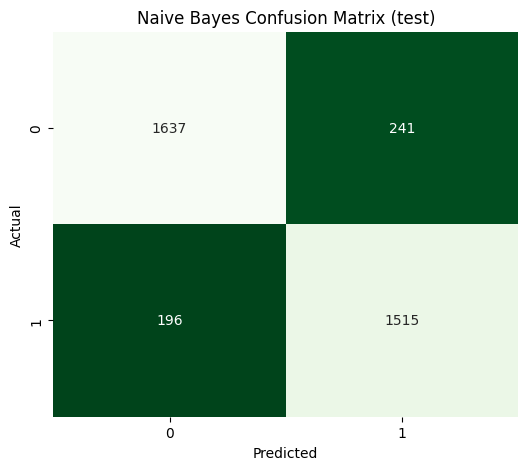

In [ ]:
#create confusion matrix png
cm = confusion_matrix(y_test, y_test_pred)


plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens_r', cbar=False,
            xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Naive Bayes Confusion Matrix (test)')
plt.savefig('NB_confusion_matrix.png', dpi=300)
plt.show()


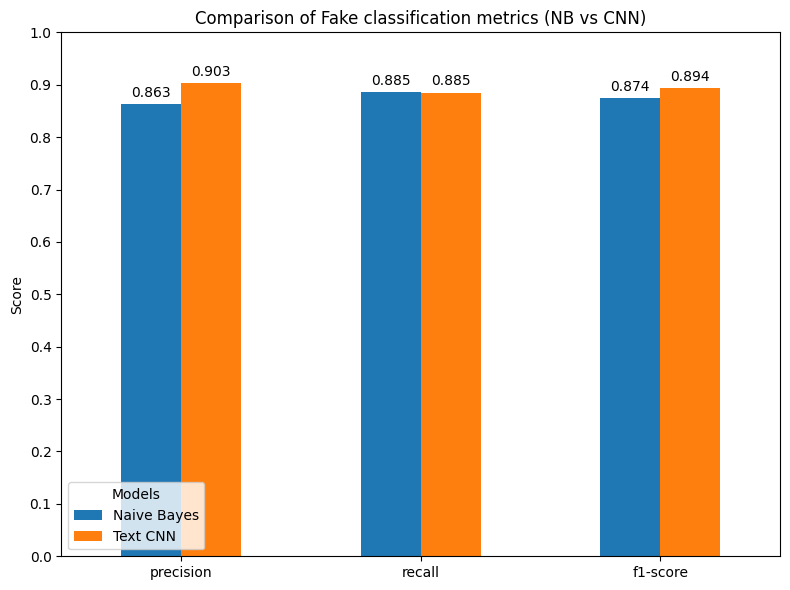

In [27]:
#create comparision visual report between NB and CNN


#classification report for both model test
NB_test = classification_report(y_test, y_test_pred, output_dict=True)
CNN_test   = classification_report(cnnTest, cnnTestPred, output_dict=True)

#metrics for fake class
metrics = ["precision", "recall", "f1-score"]

data = {
    "Naive Bayes": [NB_test["1"][m] for m in metrics],
    "Text CNN": [CNN_test["1"][m] for m in metrics]
}

df_compare = pd.DataFrame(data, index=metrics)

#plot comparison
ax = df_compare.plot(kind="bar", figsize=(8,6), rot=0)
plt.ylim(0,1)
plt.ylabel("Score")
plt.title("Comparison of Fake classification metrics (NB vs CNN)")

# y-axis 
plt.yticks(np.arange(0, 1.1, 0.1))

#add score labels on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt="%.3f", label_type='edge', padding=3)

plt.legend(title="Models")
plt.tight_layout()
plt.show()